In [1]:
## Inspect Environment
## RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [43]:
!pip install tensorflow-addons

In [44]:
import os
import time
import sys
import pdb
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
print(tf.__version__)

2.7.0


In [3]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

In [4]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)
# from data_utils import load_audio, splitsongs, hello_world2 #Every update requires Runtime Restart
# from data_utils import *
import data_utils

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [5]:
%load Documents/GitHub/VAE-based-Music--Deep-Generative-Models/data_utils.py

## Data Loading

In [6]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
MAX_SIGNAL_LEN = 80000

### Compressed 30 s audio
SAMPLE_RATE=3000
DURATION=30


GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [7]:
# DEV Test Loading file
sample_sr = 3000
# [GTZAN] The Sample length is not strictly consistent
## TODO: padding?
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, sample_sr))
ipd.Audio(sample, rate=sample_sr)

Sample Signal Shape: (1, 89796), sample Rate: 3000


In [8]:
# sample.reshape(1, 90001)

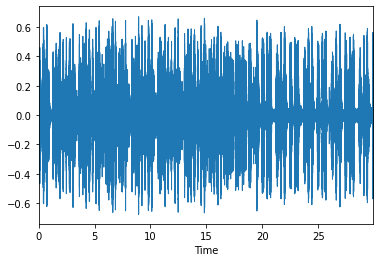

In [9]:
## Waveplot
librosa.display.waveplot(sample[0], sr=sample_sr)

In [10]:
import pdb

# def splitsongs(X, y, window = 0.05, overlap = 0.5):
#     # Empty lists to hold our results
#     temp_X = []
#     temp_y = []

#     # pdb.set_trace()

#     # Get the input song array size
#     xshape = X.shape[-1] # signal length
#     chunk = int(xshape*window)
#     offset = int(chunk*(1.-overlap))
    
#     # Split the song and create new ones on windows
#     if len(X.shape) == 1:
#     	spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
#     else:
#       spsong = [X[:, i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
#     for s in spsong:
#         # ignore the boundaries
#         if s.shape[-1] != chunk:
#             continue

#         temp_X.append(s)
#         temp_y.append(y)

#     # (#samples, 1, sample_chunk_size)
#     return np.array(temp_X), np.array(temp_y)

In [11]:
## Original Sample Splitting
(sample_splits, sample_y_splits) = data_utils.splitsongs(sample, 'hiphop', window=1.0, overlap=0.0) # break into 3s interval
print(sample_splits.shape)
print(sample_y_splits.shape)

(1, 1, 89796)
(1,)


In [12]:
X = np.array([[1,2,3,4], [2,3,4,5]])

In [13]:
X.shape

(2, 4)

In [14]:
X[:, :]

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

### Data Preprocessing

In [15]:
# ''' 
#   1. Split each single 30s song sample into smaller segment
#   2. convert each segment to melspectrogram
# '''
# def split_convert(X, y, sample_rate=3000, duration=30, max_signal_len=660000, split_window=1.0, split_overlap=0.0):
#     arr_waves, arr_genres = [], []
    
#     # Convert to spectrograms and split into small windows
#     for fn, genre in zip(X, y):
#         # for debug
#         print(f"Loading audio file: {fn}...")

#         # (1, sample_len)
#         signal = data_utils.load_audio(fn, sr=sample_rate, duration=duration)

#         # to avoid inconsistent image/spectragram size
#         signal = signal[:, :max_signal_len]

#         # Convert to dataset of spectograms/melspectograms
#         signals, y = splitsongs(signal, genre, window=split_window, overlap=split_overlap)

#         # Convert to "spec" representation
#         # specs = to_melspectrogram(signals, hop_length=512, n_fft=2048)

#         # Save files
#         print(signals.shape)
#         ## attach the forked list of sample segments
#         arr_waves.extend(signals)
#         arr_genres.extend(y)

#     # pdb.set_trace()

#     # print(len(arr_waves), arr_waves[0].shape)
#     # print(arr_genres.shape)

#     return np.array(arr_waves), np.array(arr_genres)
#     # return arr_waves, arr_genres

# '''
#  Generate data-set based on file_path for each audio sample
# - then preprocess and convert each sample accordingly
# '''
# def read_data(src_dir, genres, test_data_percentage=0.1, sample_rate=22050, duration=30, split_window=1.0, split_overlap=0.0, max_signal_len=660000):    
#     # Empty array of dicts with the processed features from all files
#     arr_fn = []
#     arr_genres = []

#     # Get file list from the folders
#     for x,_ in genres.items():
#         folder = src_dir + x
#         print(f"Loading Audio files under Genere: {x}")
#         for root, subdirs, files in os.walk(folder):
#             for file in files:
#                 file_name = folder + "/" + file

#                 ### TODO: some samples just don't load...
#                 if file_name.find('jazz/jazz.00054.wav') != -1:
#                   print(f"Skipping file: {file_name}...")
#                   continue

#                 # Save the file name and the genre
#                 arr_fn.append(file_name)
#                 # attach the label
#                 arr_genres.append(genres[x])
    
#     # Split into train and test
#     X_train, X_test, y_train, y_test = train_test_split(
#         arr_fn, arr_genres, test_size=test_data_percentage, random_state=42, stratify=arr_genres #data is split in a stratified fashion under genre label
#     )
    
#     # Split into small segments and convert to spectrogram
#     ## TODO: map this to TF DataSet process
    
#     print("Loading and Preprocessing Testing data......")
#     X_test, y_test = split_convert(X_test, y_test, sample_rate=sample_rate, duration=duration, max_signal_len=max_signal_len)

#     print("Loading and Preprocessing Training data......")
#     X_train, y_train = split_convert(X_train, y_train, sample_rate=sample_rate, duration=duration, max_signal_len=max_signal_len)

#     # return X_test, y_test
#     return X_train, y_train, X_test, y_test

In [16]:
# Loading....
# Read the data
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN)

Loading Audio files under Genere: metal
Loading Audio files under Genere: disco
Loading Audio files under Genere: classical
Loading Audio files under Genere: rock
Loading Audio files under Genere: jazz
Skipping file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00054.wav...
Loading Audio files under Genere: country
Loading Audio files under Genere: pop
Loading Audio files under Genere: blues
Loading Audio files under Genere: reggae
Loading Audio files under Genere: hiphop
Loading and Preprocessing Testing data......
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/rock/rock.00092.wav...
(1, 1, 80000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00016.wav...
(1, 1, 80000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/disco/disco.00006.wav...
(1, 1, 80000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/metal/metal.00021.wav...
(1, 1, 80000)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/hiphop/hiphop.00063.wav...
(1, 1,

In [28]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==2)[0]
print(hiphop_idx)
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)

<class 'numpy.ndarray'> (899, 1, 80000) (100, 1, 80000) (899,) (100, 1, 80000)
[6 8 8 0 3]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[ 24  34  53  62  65  73  80  87  98 105 118 120 121 130 151 161 176 177
 194 202 206 209 213 219 236 237 243 259 268 269 270 282 290 291 298 305
 307 325 328 351 357 384 386 387 394 402 404 425 442 448 449 450 462 463
 464 487 495 510 517 527 553 576 577 593 614 616 619 623 634 635 672 689
 692 696 713 753 759 767 792 795 820 825 826 836 837 845 858 864 897 898]


In [34]:
## Value range
print(np.amax(X_train), np.amin(X_train))

1.25347 -1.2434254


In [18]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_SIZE = 1000
NUM_GENERES = len(np.unique(y_train))

EPOCHS = 10
# set the dimensionality of the latent space to a plane for visualization later
LATENT_DIM = 2

print(NUM_GENERES)

10


In [19]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .batch(BATCH_SIZE))


In [31]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)

(8, 1, 80000)
(8,) tf.Tensor([2 7 7 2 2 6 3 4], shape=(8,), dtype=int32)


#### Training Data Samples (1 per genre)

In [161]:
idx_to_genres = {v:k for (k, v) in GENRES.items()}

In [162]:

# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape)

{0: [3, 5, 18, 23, 25, 48], 1: [15, 27, 37, 39, 43, 46], 2: [24, 34, 53, 62, 65, 73], 3: [4, 30, 33, 40, 45, 55], 4: [6, 10, 12, 16, 20, 21], 5: [8, 9, 19, 41, 51, 81], 6: [0, 28, 35, 47, 56, 60], 7: [11, 13, 17, 22, 29, 38], 8: [1, 2, 7, 14, 42, 61], 9: [36, 44, 54, 67, 89, 106]}
(10, 1, 80000)


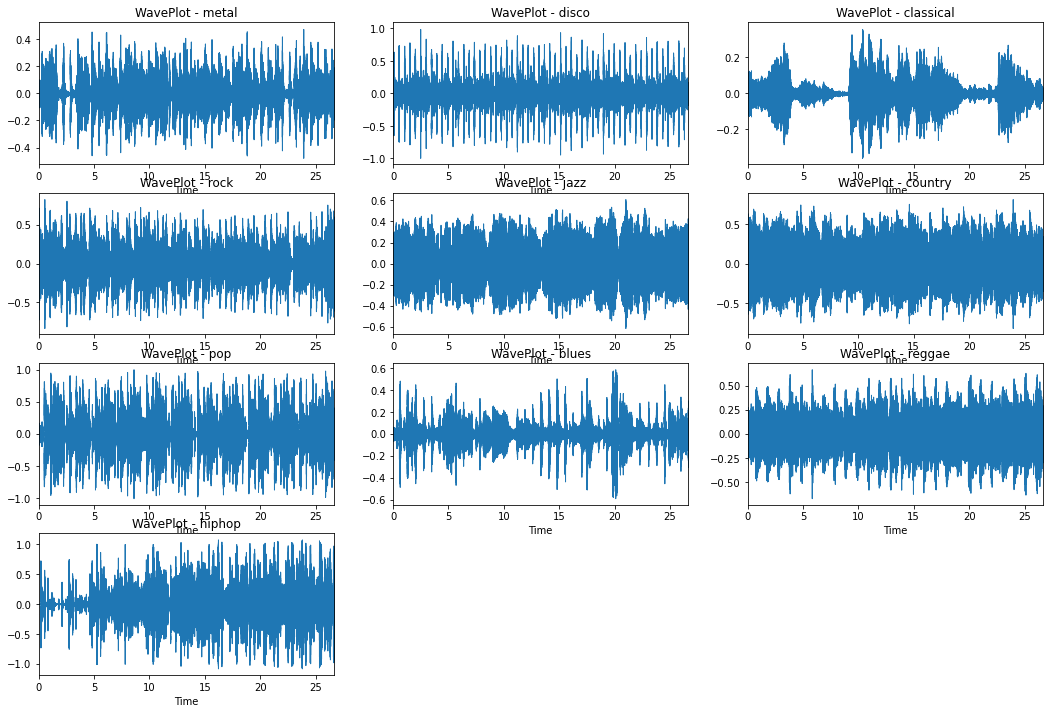

In [163]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
  
  # mel_spec_dB = librosa.amplitude_to_db(train_samples[i].squeeze()*MAX_SPEC, ref=np.max)
  
  plt.subplot(4, 3, i + 1)
  # plt.figure(figsize=(6, 3))
  # librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate)
  # plt.colorbar(format='%+1.0f dB')
  librosa.display.waveplot(train_samples[i].squeeze(), sr=3000)
  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

In [164]:
#### Validation between Epoches
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample):
  # mean, logvar = model.encode(test_sample)
  # # print('(Test Image generation) Epoch: {}, encoded mean: {}, encoded log var: {}'.format(epoch, mean, logvar))
  # z = model.reparameterize(mean, logvar) # The actual sample happens here
  # predictions = model.sample(z) # equals to directly decode here

  # Direct Reconstruction (x -> x')
  predictions = model(test_sample)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  for i in range(predictions.shape[0]):
    waves = predictions[i].numpy()
    plt.subplot(4, 3, i + 1)
    # plt.figure(figsize=(6, 3))
    # print("MEL SPEC DB: {}".format(mel_spec_dB.shape))
    if i==9:
      print("X': ", waves.squeeze())

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i].numpy())
    
  plt.show()

  return ret

## Model Structure

In [48]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = tf.keras.layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = tf.keras.layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = tf.keras.layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = tf.keras.layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [176]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    # Conv and ConvTranse layer used, but 1-D instead
    '''
    Input shape: 3+D tensor with shape: batch_shape + (steps, input_dim)

    Output shape:3+D tensor with shape: batch_shape + (new_steps, filters) 
    - new_steps decided by kernel size, padding and strides (K, P, S)
    '''
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1,MAX_SIGNAL_LEN)),
            # What's the point of applying stride?
            tf.keras.layers.Conv1D(64,1,1), # original config: layers.Conv1D(64,1,2)
            Resnet1DBlock(64,1),
            tf.keras.layers.Conv1D(128,1,1),
            Resnet1DBlock(128,1),
            tf.keras.layers.Conv1D(128,1,1),
            Resnet1DBlock(128,1),
            tf.keras.layers.Conv1D(256,1,1),
            Resnet1DBlock(256,1),
            # No activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim)

        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Reshape(target_shape=(1,latent_dim)),
            Resnet1DBlock(512,1,'decode'),
            tf.keras.layers.Conv1DTranspose(512,1,1),
            Resnet1DBlock(256,1,'decode'),
            tf.keras.layers.Conv1DTranspose(256,1,1),
            Resnet1DBlock(128,1,'decode'),
            tf.keras.layers.Conv1DTranspose(128,1,1),
            Resnet1DBlock(64,1,'decode'),
            tf.keras.layers.Conv1DTranspose(64,1,1),
            # No activation
            tf.keras.layers.Conv1DTranspose(MAX_SIGNAL_LEN,1,1),
        ]
    )
    ## Metrics
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss/latent_loss")

  '''
    Properties
  '''
  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def call(self, inputs):
      #dum call
      # print("Don't Call this dude...")
      # return inputs
      z_mean, z_log_var = self.encode(inputs)
      z = self.reparameterize(z_mean, z_log_var)
      reconstruction = self.decode(z)

      return reconstruction


  # @tf.function
  def train_step(self, data):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    # For Debug
    # tf.print("[Debug]Input Data Shape: ", data[0].shape, data[1].shape)

    with tf.GradientTape() as tape:
      loss, reconstruction_loss, kl_loss = self.compute_loss(data[0])
      # print(f"Training Loss to Back Prop: {loss}")
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.total_loss_tracker.update_state(loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


  def compute_loss(self, x):
    '''
    @param x: the input data
    '''
    # DEBUG
    # print(f"======= [DEBUG] This is the propoer KL based Loss Computation...")
    z_mean, z_log_var = self.encode(x)
    z = self.reparameterize(z_mean, z_log_var)
    # (B, 1, LEN/T)
    reconstruction = self.decode(z) # Non-Activated Linear output: raw logits

    ## TODO: Under MSE, is this still cross_ent?
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    reconstruction_loss = tf.reduce_mean(
        ## TODO: loss exploding...
        tf.reduce_sum(
            mse(x, reconstruction), axis=(1) # sum up all pixles and average by instance
            # mse(x, reconstruction)/self.train_var.squeeze(), axis=(1, 2) # Scaled by training data-set 'pixel-level' variance sum up all pixles and average by instance
        )
        # #ENT (Binary Cross Entropy) 
        ##TODO: loss is stable, but the constructed audio is almost Zero Array
        # tf.reduce_sum(
        #     tf.keras.losses.binary_crossentropy(x, reconstruction, from_logits=True), axis=(1)
        # )

        # tf.reduce_sum(
        #     tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstruction, labels=x), axis=(1,2)
        # )

        # mse(y_true=x, y_pred=reconstruction)
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss

    print(f"Reconstruction Loss/MSE: {reconstruction_loss}, KL: {kl_loss}")

    return total_loss, reconstruction_loss, kl_loss

  # @tf.function
  def sample(self, eps=None):
      if eps is None:
          # (Batch, DIM_Z)
          eps = tf.random.normal(shape=(200, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)
  # @tf.function
  def encode(self, x):
      mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
      return mean, logvar

  # @tf.function
  def reparameterize(self, mean, logvar):
      # eps = tf.random.normal(shape=mean.shape)
      # return eps * tf.exp(logvar * .5) + mean
        # $$$$ sample the stochastic epsilon
      print(f"[DEBUG] Mean: {mean.shape}, LogVar shape: {logvar.shape}")
      # eps = tf.random.normal(shape=mean.shape)
      ## Get Shape when BatchSize == None
      batch = tf.shape(mean)[0]
      dim = tf.shape(mean)[1]
      eps = tf.random.normal(shape=(batch, dim))

      return eps * tf.exp(logvar * .5) + mean

  # @tf.function
  def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
      return logits

In [177]:
test_model = CVAE(LATENT_DIM)

In [178]:
## Encoder forward pass
test_enc_out = test_model.encode(sample_batch)
print(test_enc_out[0].shape, test_enc_out[1].shape) # (B, L), (B, L)

(8, 2) (8, 2)


In [179]:
## Decoder forward pass
test_z = test_model.reparameterize(test_enc_out[0], test_enc_out[1])
test_dec_out = test_model.decode(test_z)
print(test_dec_out.shape)
print(test_dec_out[0].numpy().squeeze())

[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
(8, 1, 80000)
[0. 0. 0. ... 0. 0. 0.]


In [180]:
test_model.encoder.summary()
test_model.decoder.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_231 (Conv1D)         (None, 1, 64)             5120064   
                                                                 
 resnet1d_block_144 (Resnet1  (None, 1, 64)            4166      
 DBlock)                                                         
                                                                 
 conv1d_234 (Conv1D)         (None, 1, 128)            8320      
                                                                 
 resnet1d_block_145 (Resnet1  (None, 1, 128)           16518     
 DBlock)                                                         
                                                                 
 conv1d_237 (Conv1D)         (None, 1, 128)            16512     
                                                                 
 resnet1d_block_146 (Resnet1  (None, 1, 128)         

In [181]:
test_losses = test_model.compute_loss(sample_batch)
test_losses

[DEBUG] Mean: (8, 2), LogVar shape: (8, 2)
Reconstruction Loss/MSE: 0.018727684393525124, KL: 0.006433989852666855


(<tf.Tensor: shape=(), dtype=float32, numpy=0.025161674>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.018727684>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00643399>)

In [182]:
## DEV
sce = tf.nn.sigmoid_cross_entropy_with_logits(logits=test_dec_out, labels=sample_batch)
# tf.reduce_sum(sce, axis=[1,2])
sce

<tf.Tensor: shape=(8, 1, 80000), dtype=float32, numpy=
array([[[0.6931472 , 0.6931472 , 0.6931472 , ..., 0.6931472 ,
         0.6931472 , 0.6931472 ]],

       [[0.693533  , 0.6930883 , 0.6934447 , ..., 0.6932297 ,
         0.6929419 , 0.6931549 ]],

       [[0.6934053 , 0.693111  , 0.69328403, ..., 0.69325775,
         0.69286835, 0.69315624]],

       ...,

       [[0.6934332 , 0.69321734, 0.6935538 , ..., 0.69325465,
         0.6926585 , 0.6938883 ]],

       [[0.694228  , 0.692965  , 0.6938338 , ..., 0.69357276,
         0.6920547 , 0.69317734]],

       [[0.69518644, 0.6926979 , 0.69553924, ..., 0.6940175 ,
         0.69072133, 0.69399613]]], dtype=float32)>

In [183]:
bce = tf.keras.losses.binary_crossentropy(y_true=sample_batch, y_pred=test_dec_out, from_logits=True)
bce

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.6931461 ],
       [0.6931473 ],
       [0.6931475 ],
       [0.6931461 ],
       [0.6931469 ],
       [0.69314796],
       [0.69314885],
       [0.69314975]], dtype=float32)>

In [184]:
MSE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mse = MSE(sample_batch, test_dec_out)
mse

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.00040573],
       [0.02853128],
       [0.00915959],
       [0.0166317 ],
       [0.00023997],
       [0.06561965],
       [0.01678588],
       [0.01243919]], dtype=float32)>

[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [ 1.0613251e-06  8.6970886e-06  2.5523682e-06 ...  6.9227185e-06
 -1.0858075e-05  2.4452174e-05]


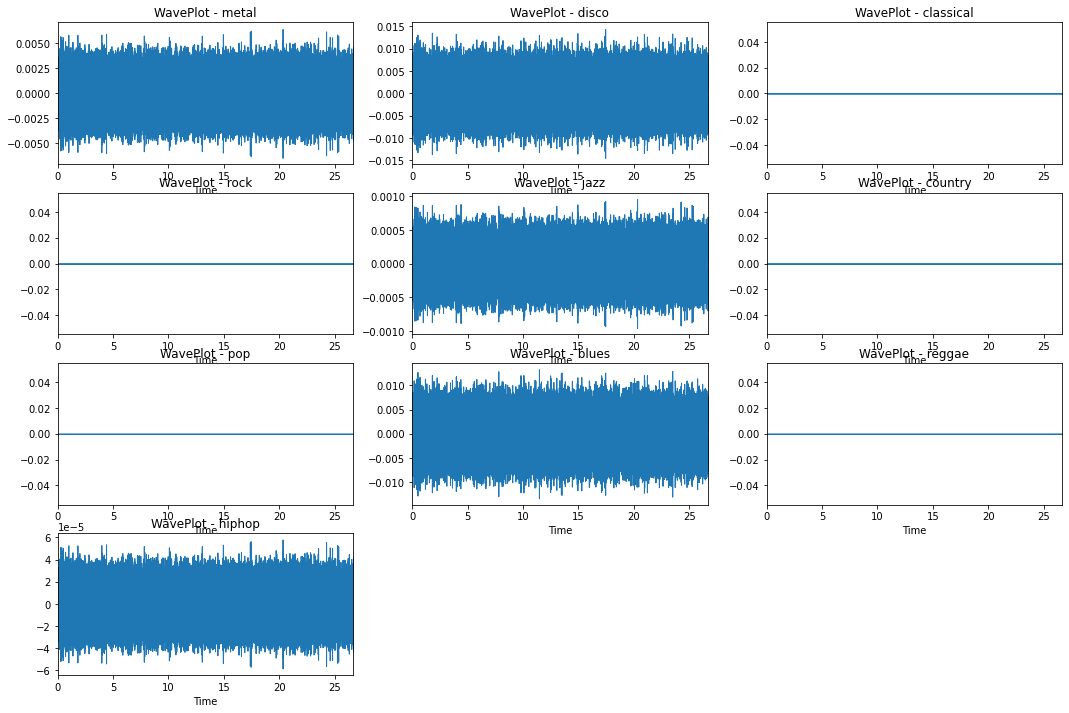

[array([[ 0.00011729,  0.00096115,  0.00028207, ...,  0.00076505,
         -0.00119996,  0.0027023 ]], dtype=float32),
 array([[ 0.00136481,  0.00124342,  0.00271422, ...,  0.00062871,
         -0.00320768,  0.00545162]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 1.7417122e-05,  1.4272460e-04,  4.1885844e-05, ...,
          1.1360607e-04, -1.7818763e-04,  4.0127520e-04]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 0.00260418,  0.00015138,  0.00295837, ...,  0.00119202,
         -0.00330947,  0.00347696]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 1.0613251e-06,  8.6970886e-06,  2.5523682e-06, ...,
          6.9227185e-06, -1.0858075e-05,  2.4452174e-05]], dtype=float32)]

In [185]:
generate_and_save_waves(test_model, 0, train_samples)

## Training

#### Training with 'FIT'

In [188]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % 5 == 0:
        print("[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        # generate_and_save_images(self.model, epoch, val_samples)
        generate_and_save_waves(self.model, epoch, train_samples)

vae_monitor = VAEMonitor()

(1, 80000)
Epoch 1/100
[DEBUG] Mean: (None, 2), LogVar shape: (None, 2)
Reconstruction Loss/MSE: Tensor("Mean:0", shape=(), dtype=float32), KL: Tensor("Mean_1:0", shape=(), dtype=float32)
[DEBUG] Mean: (None, 2), LogVar shape: (None, 2)
Reconstruction Loss/MSE: Tensor("Mean:0", shape=(), dtype=float32), KL: Tensor("Mean_1:0", shape=(), dtype=float32)
112/113 [============================>.] - ETA: 0s - loss: 0.0323 - reconstruction_loss: 0.0210 - kl_loss: 0.0114[DEBUG] This is Callback Monitor: End of Epoch 0
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [-0.00282319 -0.00952082 -0.00774881 ...  0.00926926  0.00664319
  0.00430619]


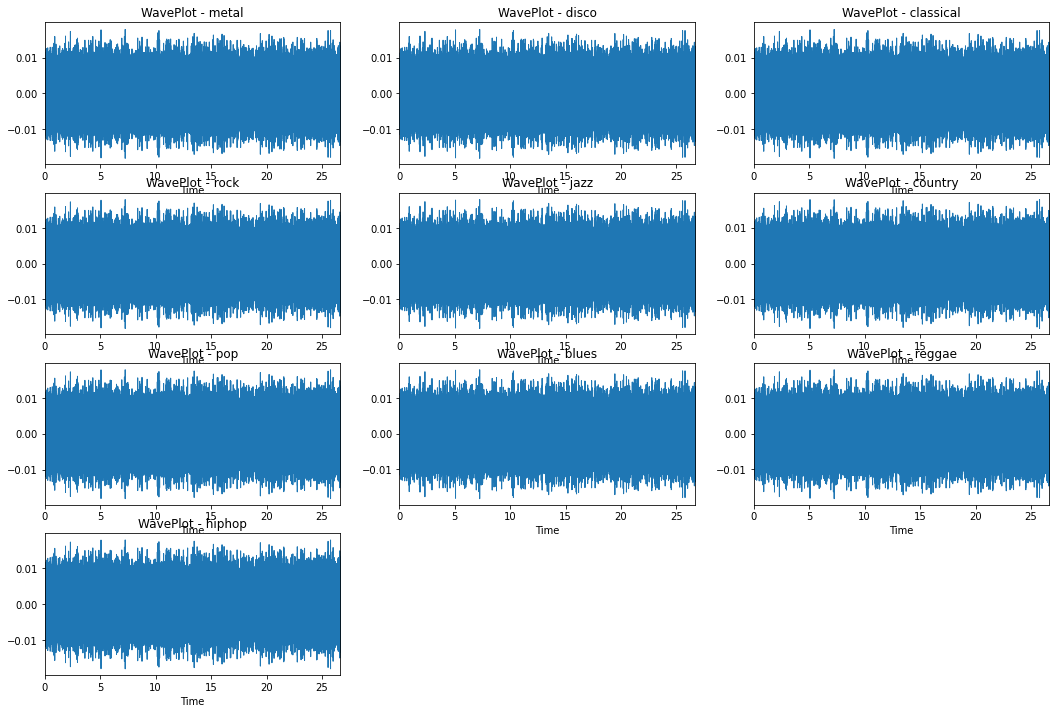

113/113 [==============================] - 10s 45ms/step - loss: 0.0322 - reconstruction_loss: 0.0209 - kl_loss: 0.0114
Epoch 2/100
113/113 [==============================] - 4s 33ms/step - loss: 0.3713 - reconstruction_loss: 0.0209 - kl_loss: 0.3502
Epoch 3/100
113/113 [==============================] - 4s 33ms/step - loss: 0.2976 - reconstruction_loss: 0.0209 - kl_loss: 0.2776
Epoch 4/100
113/113 [==============================] - 4s 34ms/step - loss: 20.7966 - reconstruction_loss: 0.0272 - kl_loss: 20.7686
Epoch 5/100
113/113 [==============================] - 4s 34ms/step - loss: 0.3433 - reconstruction_loss: 0.0212 - kl_loss: 0.3225
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.4489 - reconstruction_loss: 0.0209 - kl_loss: 0.4293[DEBUG] This is Callback Monitor: End of Epoch 5
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [-0.00361756 -0.01156022 -0.00928216 ...  0.0170994   0.00927894
  0.0040549 ]


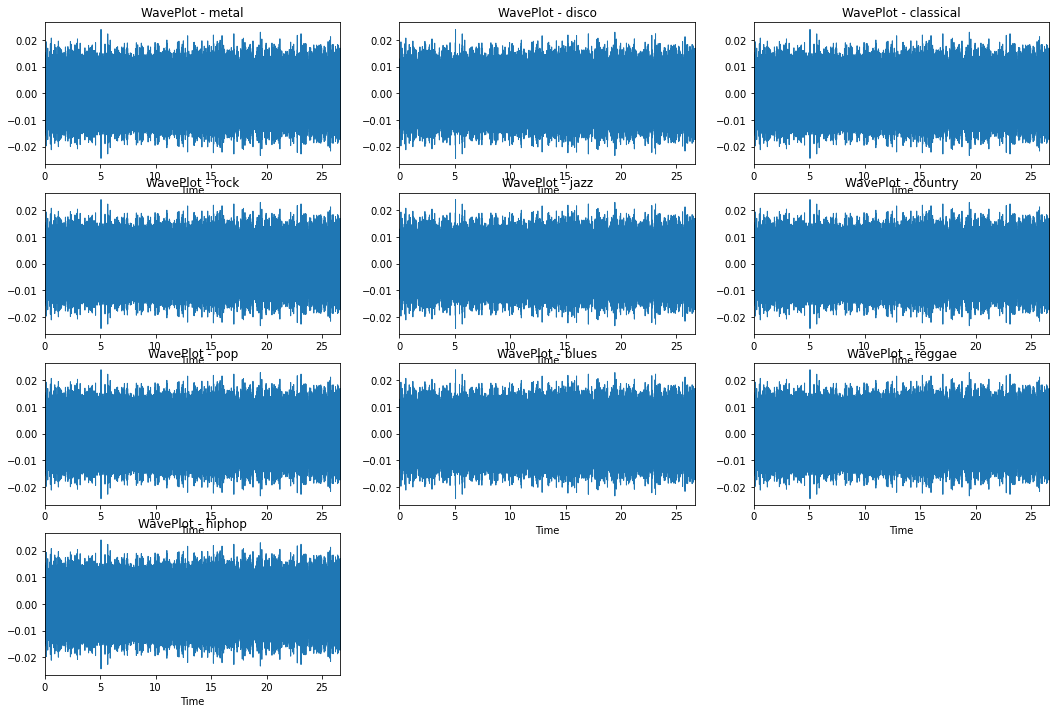

113/113 [==============================] - 5s 46ms/step - loss: 0.4483 - reconstruction_loss: 0.0209 - kl_loss: 0.4286
Epoch 7/100
113/113 [==============================] - 4s 34ms/step - loss: 0.2833 - reconstruction_loss: 0.0210 - kl_loss: 0.2611
Epoch 8/100
113/113 [==============================] - 4s 33ms/step - loss: 1.4367 - reconstruction_loss: 0.0210 - kl_loss: 1.4145
Epoch 9/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0299 - reconstruction_loss: 0.0209 - kl_loss: 0.0084
Epoch 10/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0297 - reconstruction_loss: 0.0210 - kl_loss: 0.0086
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.0215 - reconstruction_loss: 0.0209 - kl_loss: 4.7149e-04[DEBUG] This is Callback Monitor: End of Epoch 10
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [-0.00256397 -0.00667611 -0.0054732  ...  0.01181446  0.01241406
  0.00846424]


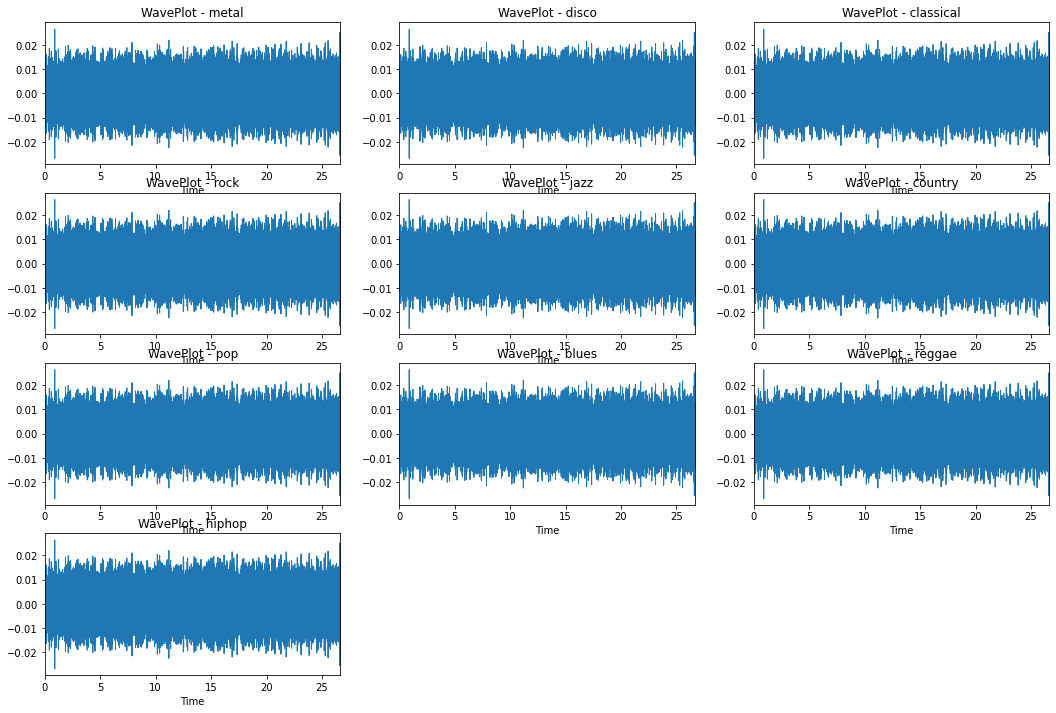

113/113 [==============================] - 5s 45ms/step - loss: 0.0215 - reconstruction_loss: 0.0209 - kl_loss: 4.7081e-04
Epoch 12/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0213 - reconstruction_loss: 0.0209 - kl_loss: 2.6494e-04
Epoch 13/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0213 - reconstruction_loss: 0.0209 - kl_loss: 2.3348e-04
Epoch 14/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0204 - reconstruction_loss: 0.0211 - kl_loss: 1.9149e-04
Epoch 15/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0216 - reconstruction_loss: 0.0210 - kl_loss: 1.7251e-04
Epoch 16/100
113/113 [==============================] - ETA: 0s - loss: 0.0205 - reconstruction_loss: 0.0209 - kl_loss: 1.6134e-04[DEBUG] This is Callback Monitor: End of Epoch 15
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [-0.00053755 -0.00866416 -0.00604955 ...  0.0140116   0.01171688
  0.00903596]


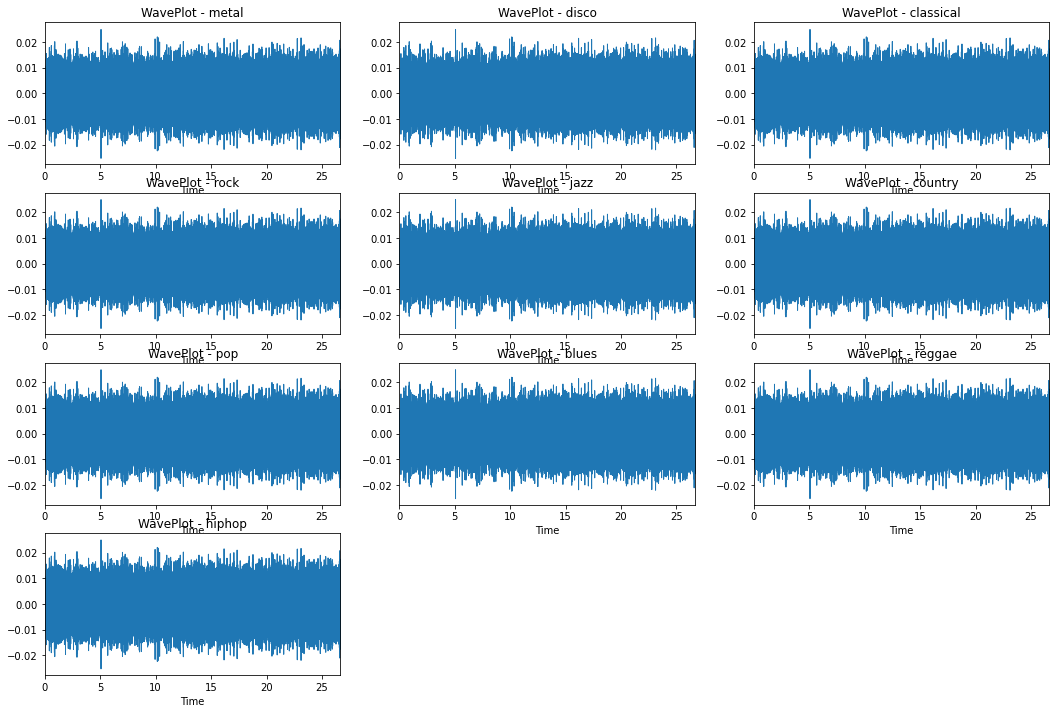

113/113 [==============================] - 5s 45ms/step - loss: 0.0205 - reconstruction_loss: 0.0209 - kl_loss: 1.6111e-04
Epoch 17/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0201 - reconstruction_loss: 0.0209 - kl_loss: 8.5840e-05
Epoch 18/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0220 - reconstruction_loss: 0.0210 - kl_loss: 7.6385e-05
Epoch 19/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0204 - reconstruction_loss: 0.0211 - kl_loss: 3.1709e-05
Epoch 20/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0209 - reconstruction_loss: 0.0211 - kl_loss: 2.2572e-05
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.0210 - reconstruction_loss: 0.0210 - kl_loss: 1.5579e-05[DEBUG] This is Callback Monitor: End of Epoch 20
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [ 0.00524191 -0.0100508  -0.00822026 ...  0.01250283  0.00223286
 -0.00043211]


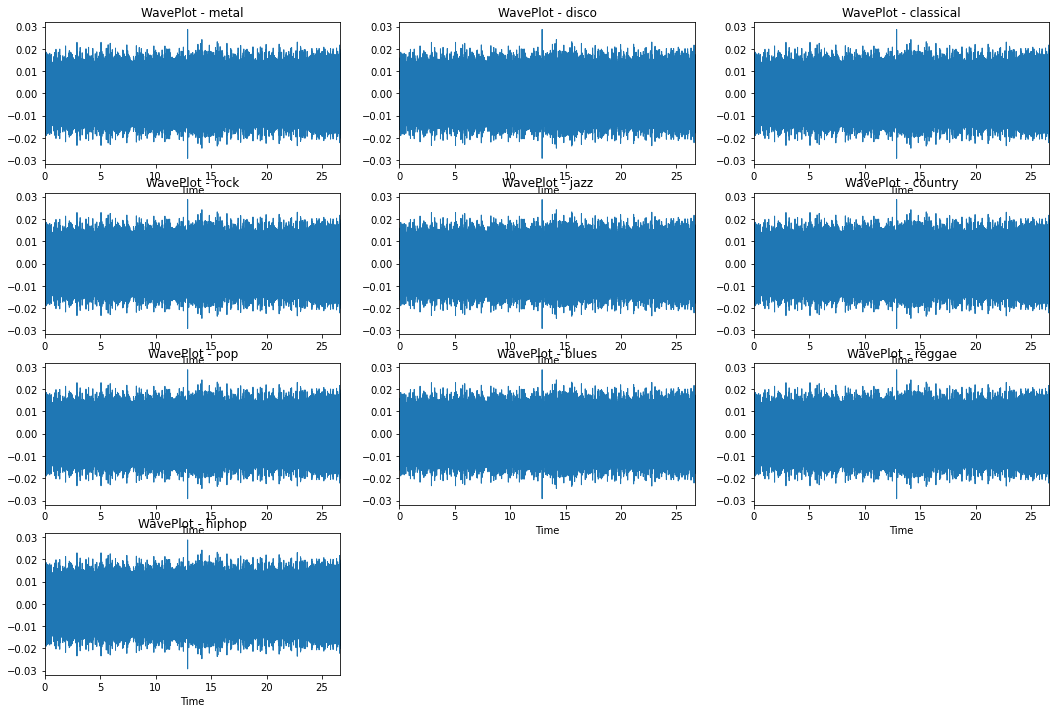

113/113 [==============================] - 5s 45ms/step - loss: 0.0210 - reconstruction_loss: 0.0210 - kl_loss: 1.5616e-05
Epoch 22/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0208 - reconstruction_loss: 0.0209 - kl_loss: 1.9963e-05
Epoch 23/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0210 - reconstruction_loss: 0.0209 - kl_loss: 1.0795e-05
Epoch 24/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0210 - reconstruction_loss: 0.0210 - kl_loss: 1.6410e-05
Epoch 25/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0202 - reconstruction_loss: 0.0209 - kl_loss: 6.8702e-06
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.0196 - reconstruction_loss: 0.0210 - kl_loss: 6.6538e-06[DEBUG] This is Callback Monitor: End of Epoch 25
[DEBUG] Mean: (10, 2), LogVar shape: (10, 2)
X':  [ 0.00039503 -0.0043497  -0.00580928 ...  0.01467574  0.0142161
  0.01149655]


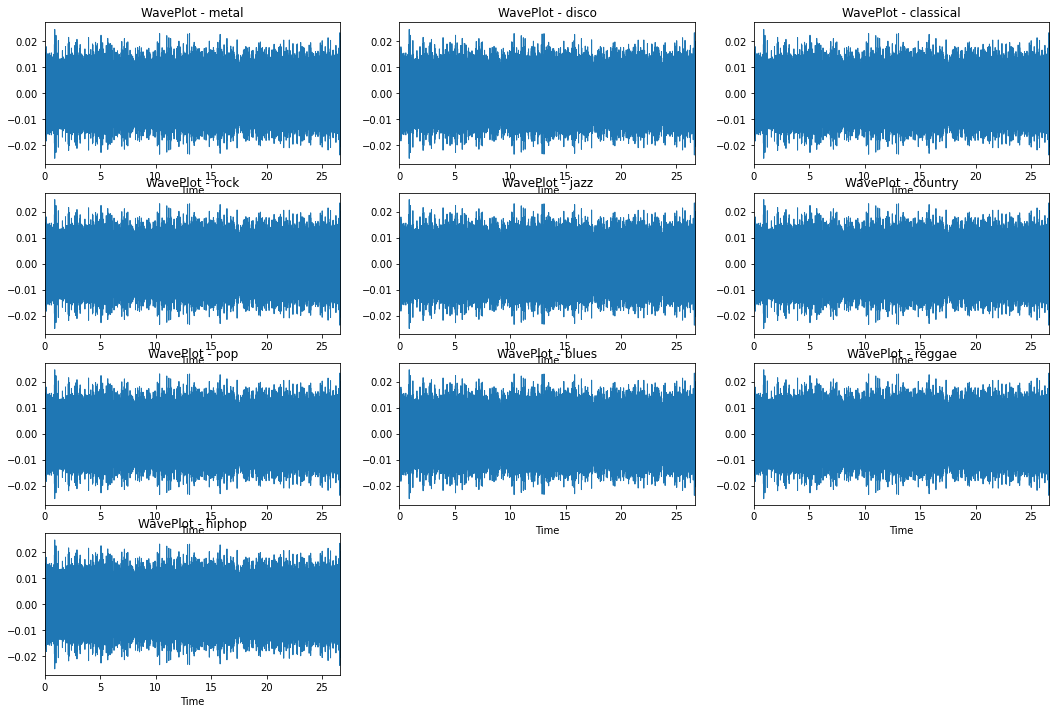

113/113 [==============================] - 5s 45ms/step - loss: 0.0197 - reconstruction_loss: 0.0210 - kl_loss: 6.6611e-06
Epoch 27/100
113/113 [==============================] - 4s 39ms/step - loss: 0.0211 - reconstruction_loss: 0.0210 - kl_loss: 4.8022e-06
Epoch 28/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0206 - reconstruction_loss: 0.0209 - kl_loss: 5.2574e-06
Epoch 29/100
113/113 [==============================] - 4s 34ms/step - loss: 0.0215 - reconstruction_loss: 0.0209 - kl_loss: 8.5630e-06
Epoch 30/100
113/113 [==============================] - 4s 33ms/step - loss: 0.0212 - reconstruction_loss: 0.0210 - kl_loss: 8.0469e-06
Epoch 31/100
 49/113 [============>.................] - ETA: 2s - loss: 0.0212 - reconstruction_loss: 0.0212 - kl_loss: 1.5006e-05

In [ ]:
input_shape = sample_batch.shape[1:]
print(input_shape)
vae_model = CVAE(LATENT_DIM)

# Callback 0: Learning Rate Scheduler
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=0.0000001, min_delta=1.0)
vae_model.compile(optimizer=tf.keras.optimizers.Adam())
# vae_model.fit(train_dataset, epochs=300, callbacks=[vae_monitor, reduce_lr])

vae_model.fit(train_dataset, epochs=100, callbacks=[vae_monitor])

In [ ]:
val_loss_history = []
train_loss_history = []


# generate_and_save_images(model, 0, val_samples)

for epoch in range(1, 2):
  start_time = time.time()
  for (step, train_data) in enumerate(train_dataset):
    # print(train_x.shape, train_y.shape)
    train_loss = vae_model.train_step(train_data)
    train_loss_history.append(train_loss)

    if step%50 == 0:

      print('========= Epoch:{} Batch:{}, Train Loss for minimization: {}, time elapse for current epoch: {}'
        .format(epoch, step, train_loss, time.time() - start_time))
  end_time = time.time()